In [ ]:
# default_exp examples.multilabel_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# examples.multilabel_classification

> This is an example of how to use blurr for multilabel classification tasks

In [ ]:
#export
import torch, datasets
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#cuda
#hide_input
#hide_output
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


Here's what we're running with ...

In [ ]:
#hide_input
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1
Using fastai 2.4
Using transformers 4.6.1


Let's start by building our `DataBlock`

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = datasets.load_dataset('civil_comments', split='train[:1%]') 
len(raw_data)

Using custom data configuration default
Reusing dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


18049

In [ ]:
toxic_df = pd.DataFrame(raw_data, columns=list(raw_data.features.keys()))
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.0,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

In [ ]:
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=16)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([16, 391]), torch.Size([16, 6]))

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 391 x 768      
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
           

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([16, 6]),
 SequenceClassifierOutput(loss=None, logits=tensor([[-0.1480, -0.1027,  0.0931, -0.3318, -0.0891, -0.0882],
         [-0.1401, -0.1007,  0.1079, -0.3418, -0.0928, -0.0850],
         [-0.1416, -0.0953,  0.1074, -0.3318, -0.0861, -0.0855],
         [-0.1299, -0.0986,  0.1004, -0.3482, -0.0834, -0.0991],
         [-0.1449, -0.1041,  0.0951, -0.3315, -0.0817, -0.0961],
         [-0.1555, -0.1025,  0.0920, -0.3258, -0.0775, -0.0882],
         [-0.1383, -0.0999,  0.1107, -0.3360, -0.0874, -0.0818],
         [-0.1415, -0.0930,  0.0894, -0.3442, -0.0751, -0.1044],
         [-0.1433, -0.0938,  0.1048, -0.3313, -0.0829, -0.0810],
         [-0.1453, -0.0994,  0.1089, -0.3423, -0.0794, -0.0782],
         [-0.1448, -0.0907,  0.1019, -0.3448, -0.0818, -0.0975],
         [-0.1447, -0.0949,  0.0940, -0.3516, -0.0805, -0.1113],
         [-0.1470, -0.0965,  0.0912, -0.3424, -0.0852, -0.0983],
         [-0.1447, -0.0980,  0.1006, -0.3306, -0.0710, -0.0694],
         [-0.1360, -0.088

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0008))

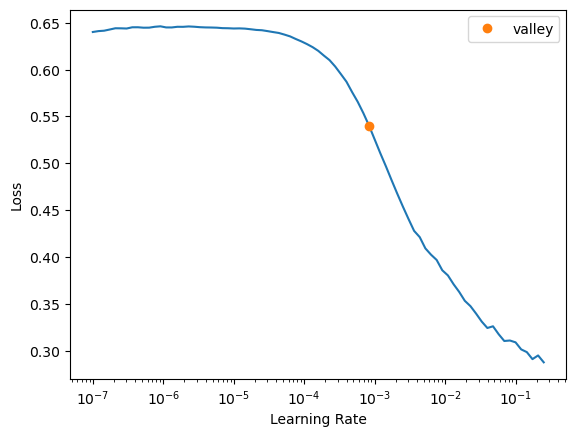

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.037688,0.036035,0.992657,01:02


SuggestedLRs(valley=tensor(1.5488e-11))

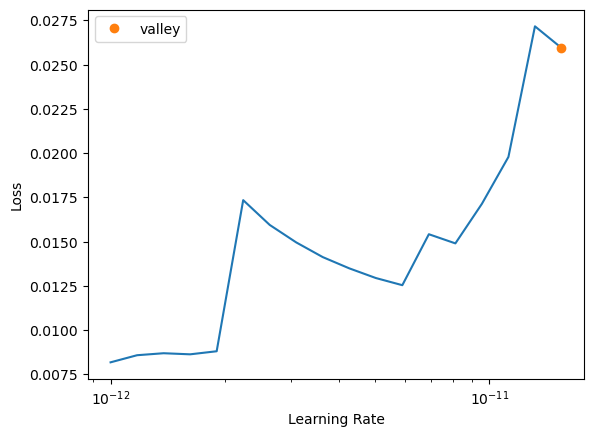

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=1e-12, end_lr=1e-5)

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(1e-10, 4e-9))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035135,0.036035,0.992657,01:37
1,0.042295,0.036035,0.992657,01:38


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"As usual WW plumbing the depths for deeper meaning... that is unless it involves an issue on which they disagree then it is ridicule 24/7. Clever creating the Bundyland series complete with cartoon banner. Set the tone for the level of journalism to expect... journalism? ... fatastisticism. \n\nI did notice you soft pedaling the ridicule of David Fry identifying him as troubled. My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics. Respect is never a factor with liberals as evidenced by your series of vapid caricatures. \n\nDid you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge? The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon. Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbitrary over reaching Federal Government policies. Or how about the thousands of miles of roads proposed to be removed from Oregon wild lands, cutting off public and fire access? What is the one issue the people of Oregon demand universally? Access to the wild lands? You are not reporting that it is being taken away. More closed roads. More illegal Federal Police, guns drawn, stops... as reported by the Sheriff of Grant County. \n\nI suspect the real problem was real people you couldn't care less about were articulate, were actual victims, and made rational arguments you could not respond to. The exact opposite of the great unbathed OWS movement, apart from the paid organizers, that held downtown Portland hostage and trashed 3 park blocks for 3 weeks. \n\nShame on you. You missed some really great stories and even greater people... people who don't drink $5 cups of coffee.",,[]
1,"Wow. Congratulations, Ms. Monahan. You have just been played by some of the wealthiest white families in Portland. With fair and balanced reporting like this, who needs Fox News?\n\nThe mexican sombrero here conveys so much about where this article comes from (sure, all Latinos are basically Mexican, right?... or is it Olympic athletes?). It's the same insidious racism that has John101 talking about people putting on ""fake accents"", and prompted some parents to suggest that Latino nannies had been paid to show up in support of keeping Ainsworth neighborhood and Spanish Immersion programs integrated at the same school (as they've been successfully for 30 years). Both untrue.\n\nLet's not forgot how displacing the Spanish Immersion program from Ainsworth got on the table: As a rushed and desperate 11th hour response when families in Council Crest, Healy Heights and Greenhills neighborhoods had their children and homes considered by PPS for redistricting to other schools.\n\nHypocrisy, indeeed.",,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

[(((#1) ['insult'],),
  (#1) [tensor([False, False, False,  True, False, False])],
  (#1) [tensor([1.3316e-05, 8.7791e-03, 3.5837e-04, 3.3086e-02, 3.3898e-03, 2.1240e-03])])]

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([3609, 6]), torch.Size([3609, 6]), torch.Size([3609]))

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
